# Project 4 Stereo camera calibration

This week you'll be provided with a set of stereo images, and your task is to undistort and rectify the images, such that they can be used with the stereo depth reconstruction you made on day 6. You are still not allowed to use opencv functions for block matching/template matching, however you are free to use opencv when undistorting the images. It is recommended that you finish the exercises from Monday before continuing with the weekly project.

The image sets are found in the attached zip-file. Start with the rs.zip and move on to mynteye.zip once you have it working. The physical dimensions of each square of the pattern are 33.6 x 33.6 mm.

Hint: You'll have to undistort the images before rectifying them.



### So far the best procedure found has been:

#### Undistortion images
1. For all right and left images find the chessboardcorners: objectpoints IRL and imagepoint on imageplane.
2. Use cv2.CalibrateCamera() to get distortion coefficients from the imagepoints
3. Then use cv2.getOptimalNewCameraMatrix(), which is RANSAC + SVD (DLT) to get optimal K matrix.

#### Stereo calibration
1. use cv2.stereoCalibrate() to get R, t, E and F matrix connecting the cameras..
2. Then, use cv2.stereoRectify() to get rotation, translation and projection of each camera.
3. Finally we can use cv2.initUndistortRectifyMap() to create a complete map, which can be used to undistort and rectify all images from the camera. 
        - This is applied using "cv2.remap()"

#### Alternatively

A more intuitive approach, closer to the math, not using stereoCalibrate() can be found from ex4.
Again use cv2.getOptimalNewCameraMatrix() on all corners of the chessboard to estimate the camera matrices K1, K2.

Distortion coefficients for both cameras are again found using the imagepoints and cv2.CalibrateCamera()

THen find F using cv2.findFundamentalMat(pts1, pts2, method=cv2.FM_RANSAC) where pt1 and pts2 correspond to the 200 best matches found between the two images. Since some of them are outliers its nice to use RANSAC.

E matrix is then found using the definition of E and F: E = K_left.T@F@K_right. 

The rotations and translation is given by cv2.decomposeEssentialMat(E): NB! its just two possible rotations being returned, not left and right!

Then instead of using cv2.stereoRectify() we use the definition of the projection matrices to get them:
P_left = np.hstack((K_left@R_left, K_left@t))
P_right = np.hstack((K_right@R_right, K_right@t))


Now we are ready to produce some maps! cv2.initUndistortRectifyMap(K, dist, R, P,(w,h),cv2.CV_32FC1).

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
#from sklearn import linear_model


First we want to undistort the images, and then rectify them. To undistort we need to extract imagepoints for each camera, which we will also use to estimate F.
We  extract corners of calibration chessboard, used to undistort the image. We do this for the left and right camera, in case they have different distortion

In [3]:
#Number of vertical and horizontal corners
nb_vertical = 9
nb_horizontal = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nb_horizontal*nb_vertical,3), np.float32)
objp[:,:2] = np.mgrid[0:nb_vertical,0:nb_horizontal].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints_left = [] # 2d points in image plane.

images = glob.glob('rs/left*.png')
assert images


for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


    #findChessboardCorners here
    ret, corners = cv2.findChessboardCorners(gray,(nb_vertical,nb_horizontal))


    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        imgpoints_left.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nb_vertical,nb_horizontal), corners,ret)
        cv2.imshow('img',img)
        #cv2.waitKey(500)

cv2.destroyAllWindows()

In [4]:
#Number of vertical and horizontal corners
nb_vertical = 9
nb_horizontal = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nb_horizontal*nb_vertical,3), np.float32)
objp[:,:2] = np.mgrid[0:nb_vertical,0:nb_horizontal].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints_right = [] # 2d points in image plane.

images = glob.glob('rs/right*.png')
assert images


for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


    #findChessboardCorners here
    ret, corners = cv2.findChessboardCorners(gray,(nb_vertical,nb_horizontal))


    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        imgpoints_right.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nb_vertical,nb_horizontal), corners,ret)
        cv2.imshow('img',img)
        #cv2.waitKey(500)

cv2.destroyAllWindows()

Now, use the imagepoints to estimate the distortion coefficients of each image, as well as the projection matrix for each camera.

In [5]:
# Use object vs image points to find the distortion coefficients of the image
ret, mtx, D1, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints_left, gray.shape[::-1], None, None)
img_left = cv2.imread('rs/left-0000.png') # Get a single left image to extract its size
h,  w = img_left.shape[:2]
K1, roi = cv2.getOptimalNewCameraMatrix(mtx,D1,(w,h),1,(w,h))

In [6]:
# Use object vs image points to find the distortion coefficients of the image
ret, mtx, D2, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints_right, gray.shape[::-1], None, None)
img_right = cv2.imread('rs/right-0000.png') # Get a single right image to extract its size
h,  w = img_right.shape[:2]
K2, roi = cv2.getOptimalNewCameraMatrix(mtx,D2,(w,h),1,(w,h))

In [9]:
# We can now confirm that the two cameras are pretty similar when it comes to camera matrices.
K1, K2

(array([[365.89266968,   0.        , 324.62721633],
        [  0.        , 366.50601196, 247.47156052],
        [  0.        ,   0.        ,   1.        ]]),
 array([[368.22756958,   0.        , 322.73204455],
        [  0.        , 368.8453064 , 245.85216099],
        [  0.        ,   0.        ,   1.        ]]))

Having all this information, we can now use the function stereoCalibrate() to extract rotation and translation for the camera system. 

In [10]:
ret,K1,D1,K2,D2,R,T,E,F = cv2.stereoCalibrate(objpoints,imgpoints_left,imgpoints_right,K1,D1,K2,D2,(w,h))

Having the total rotation and translation, as well as camera matrices and distortions we can get the rotation and translation required to rectify the images.

In [11]:
R1,R2,P1,P2,Q,roi_left,roi_right = cv2.stereoRectify(K1,D1,K2,D2,(w,h),R,T)

Having the rectify and undistiortion formulas, we create a map, mapping the old images to new undistorted and rectified ones.

In [12]:
leftMapX, leftMapY = cv2.initUndistortRectifyMap(K1,D1,R1,P1,(w,h),cv2.CV_32FC1)
rightMapX, rightMapY = cv2.initUndistortRectifyMap(K2,D2,R2,P2,(w,h),cv2.CV_32FC1)

These maps lets us create rectified versions of all images taken by left and right cameras! Complete calibration :D

In [79]:
img_left = cv2.imread('rs/left-0004.png')
img_right = cv2.imread('rs/right-0004.png')

left_rectified = cv2.remap(img_left,leftMapX,leftMapY,cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
right_rectified = cv2.remap(img_right,rightMapX,rightMapY,cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)

Text(0.5, 1.0, 'Undistorted and rectified image right')

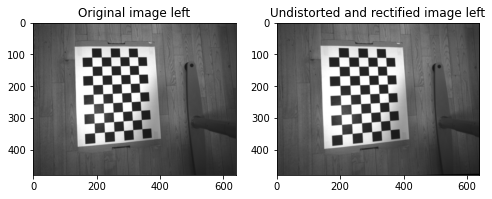

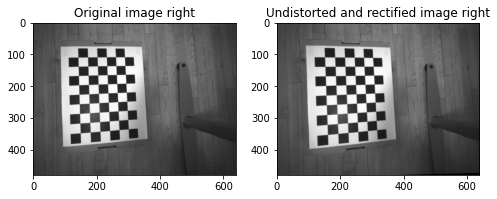

In [80]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,8))
ax[0].imshow(img_left)
ax[0].set_title('Original image left')
ax[1].imshow(left_rectified)
ax[1].set_title('Undistorted and rectified image left')
#fig.show()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,8))
ax[0].imshow(img_right)
ax[0].set_title('Original image right')
ax[1].imshow(right_rectified)
ax[1].set_title('Undistorted and rectified image right')
#fig.show()

## Verify the algorithm
Use sift to detect and compute features in both the left and right images and optionally visualize the keypoints.

If the images are truely rectified the epipolar lines should be parallell!

<Figure size 720x720 with 0 Axes>

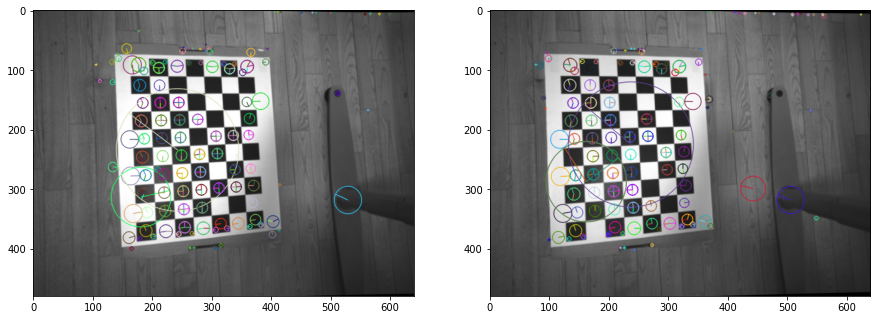

<Figure size 720x720 with 0 Axes>

In [81]:
img1 = left_rectified.copy()
img2 = right_rectified.copy()

# Create a sift detector
sift = cv2.SIFT_create()

#Detect keypoints and descriptots here
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

kp_img_left = cv2.drawKeypoints(img1, kp1, img1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
kp_img_right = cv2.drawKeypoints(img2, kp2, img2, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(15,15))
ax1.imshow(kp_img_left)
ax2.imshow(kp_img_right)
plt.figure(figsize = (10,10))

We then match the keypoints found in the exercise using either a brute force method or the flann method.

In [82]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c,_ = img1.shape
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,2)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

In [83]:
"""
Mathcers
"""
bf = cv2.BFMatcher()
matches = bf.match(des1, des2)

#flann = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
#matches = flann.match(des1, des2)

# Sort them in the order of their distance (i.e. best matches first).
matches = sorted(matches, key = lambda x:x.distance)


In [84]:

# Number of points selected
nb_matches = 200

good = []
pts1 = []
pts2 = []

# Using 200 best matches
for m in matches[:nb_matches]:
    good.append(m)
    # Extract points corresponding to matches.
    pts1.append(kp1[m.queryIdx].pt)
    pts2.append(kp2[m.trainIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
    
"""
Find the fundamental matrix: SVD + RANSAC
"""
F, mask =cv2.findFundamentalMat(pts1, pts2, method=cv2.FM_RANSAC)

# We select only inlier points.
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]

Display the results of our first images

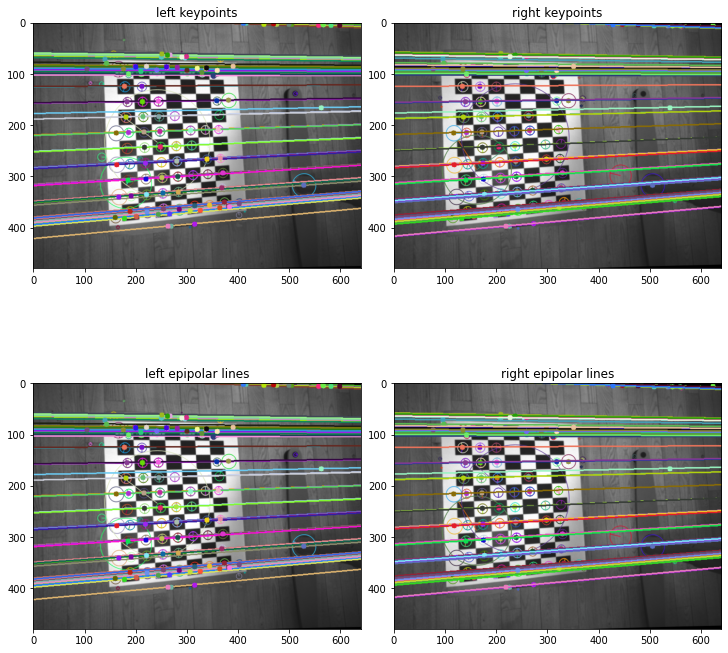

In [85]:

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2 ,F)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img1, img2, lines1, pts1, pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img2, img1, lines2, pts2, pts1)

fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(10,10))
axs[0, 0].imshow(img4)
axs[0, 0].set_title('left keypoints')
axs[0, 1].imshow(img6)
axs[0, 1].set_title('right keypoints')
axs[1, 0].imshow(img5)
axs[1, 0].set_title('left epipolar lines')
axs[1, 1].imshow(img3)
axs[1, 1].set_title('right epipolar lines')
plt.show()